Importamos lo necesario para el Script.

In [1]:
#CIL
from cil.io import NikonDataReader
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector, Binner, AbsorptionTransmissionConverter
from cil.optimisation.functions import IndicatorBox
from cil.optimisation.algorithms import CGLS, SIRT, PDHG
from cil.utilities.display import show2D, show1D, show_geometry
from cil.utilities.jupyter import islicer
from cil.optimisation.operators import IdentityOperator
from cil.optimisation.functions import L2NormSquared, L1Norm
#from cil.utilities import dataexample

# TIGRE
from cil.recon import FDK as FDKTigre
from cil.plugins.tigre import ProjectionOperator as ProjectionOperatorTigre
from cil.plugins.tigre import FBP as FBPTigre

# Astra
from cil.plugins.astra.processors import FBP as FBPAstra
from cil.plugins.astra.operators import ProjectionOperator as ProjectionOperatorAstra

# Plugins
from cil.plugins import TomoPhantom

# Otros
import os
import numpy as np
import matplotlib.pyplot as plt
import logging

Guardamos la ruta donde se encuentra nuestro archivo `xtekct` del tomografo Nikon.

In [2]:
filename = "Cili\CS180.xtekct"

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\TalentPC\AppData\Local\Temp\ipykernel_6608\3574950331.py:1: SyntaxWarning: invalid escape sequence '\C'
  filename = "Cili\CS180.xtekct"


In [3]:
import logging
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

Para que se puedan leer los datos de entrada, el archivo `xteckt` debe de estar en la misma carpeta que las proyecciones. Para este caso está en la misma carpeta que las 180 imagenes .Tif del cilindro.

In [4]:
data_in = NikonDataReader(file_name=filename).read()

In [5]:
print(data_in)

Number of dimensions: 3
Shape: (180, 499, 500)
Axis labels: ('angle', 'vertical', 'horizontal')



In [6]:
# print the geometry data associated with the data
print(data_in.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [  0.    , -87.9998,   0.    ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  -0.    , 1019.0002,    0.    ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [500 499]
	Pixel size: [0.1 0.1]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 180
	Angles 0-9 in degrees: [174.20728, 172.20728, 170.20726, 168.20724, 166.20723, 164.20721,
 162.2072 , 160.20718, 158.20718, 156.20717]
	Angles 170-179 in degrees: [-165.79492, -167.79495, -169.79495, -171.79498, -173.79498, -175.79501,
 -177.79501, -179.79501, -181.79504, -183.79504]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


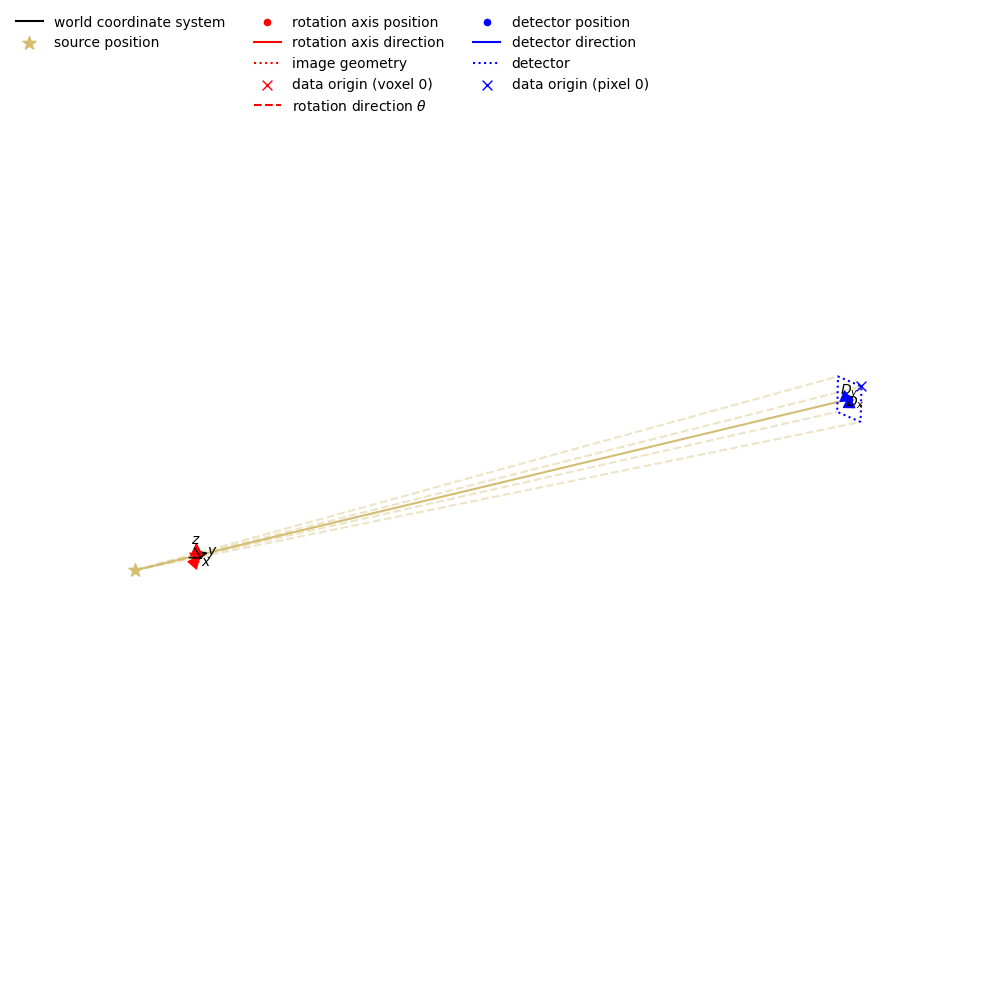

In [7]:
# display the geometry
show_geometry(data_in.geometry, elevation=20, azimuthal=- 35, view_distance=10, figsize=(10, 10), fontsize=10)

In [8]:
islicer(data_in, direction='angle',size=10, origin='upper')

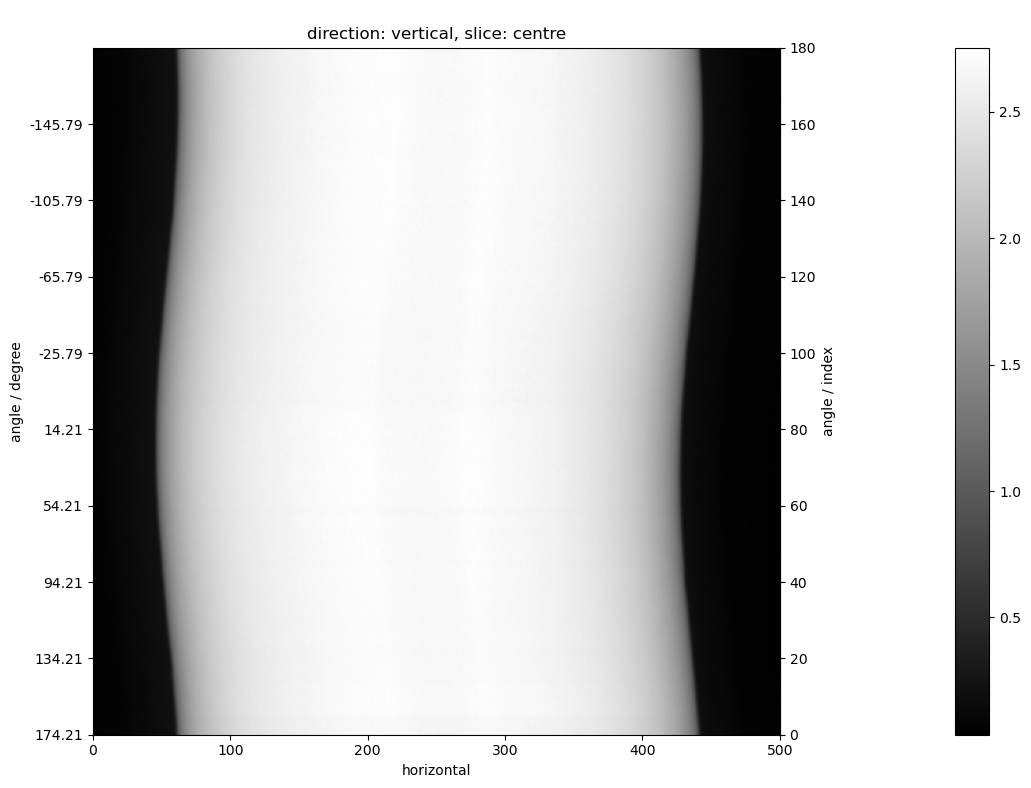

In [9]:
# calculate the absorption data using the Beer–Lambert law
data_absorption = TransmissionAbsorptionConverter()(data_in)

# show the centre slice using show2D
show2D(data_absorption, slice_list=('vertical', 'centre'))

In [10]:
ag = NikonDataReader(file_name=filename).get_geometry()
ig = ag.get_ImageGeometry()

# FDK TIGRE

In [11]:
data_absorption.reorder(order='tigre')
data_centred = CentreOfRotationCorrector.image_sharpness(backend='tigre', search_range=100, tolerance=0.1)(data_absorption)

INFO:cil.processors.CofR_image_sharpness:evaluated 11 points
INFO:cil.processors.CofR_image_sharpness:Centre of rotation correction found using image_sharpness
INFO:cil.processors.CofR_image_sharpness:backend FBP/FDK tigre
INFO:cil.processors.CofR_image_sharpness:Calculated from slice: centre
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 5.324566 pixels
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 0.042327 units at the object
INFO:cil.processors.CofR_image_sharpness:Return new dataset with centred geometry


In [12]:
ag2 = data_centred.geometry
ig2 = ag2.get_ImageGeometry()

In [13]:
# reorder the data for the `tigre` backend
#data_absorption.reorder(order='tigre')

# create the FDK reconstructor
fdk =  FDKTigre(data_centred, ig2)

# run the reconstructor
recon = fdk.run()

FDK recon

Input Data:
	angle: 180
	vertical: 499
	horizontal: 500

Reconstruction Volume:
	vertical: 499
	horizontal_y: 500
	horizontal_x: 500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 10
	Filter_inplace: False



In [14]:
# visualise the 3D reconstructed volume
islicer(recon, direction='vertical', size=10, cmap="gray") # change to 'horizontal_y' or 'horizontal_x' to view the data in other directions
#show2D(recon, slice_list=[('vertical',250), ('horizontal_x', 250)], fix_range=(-0.01, 0.1))

# FBP ASTRA

In [19]:
data_absorption.reorder('astra')
recon = FBPAstra(image_geometry=ig, acquisition_geometry=data_absorption.geometry, device='gpu')(data_absorption)
#recon = FBPAstra(image_geometry=ig2, acquisition_geometry=data_absorption.geometry, device='gpu')(data_centred)

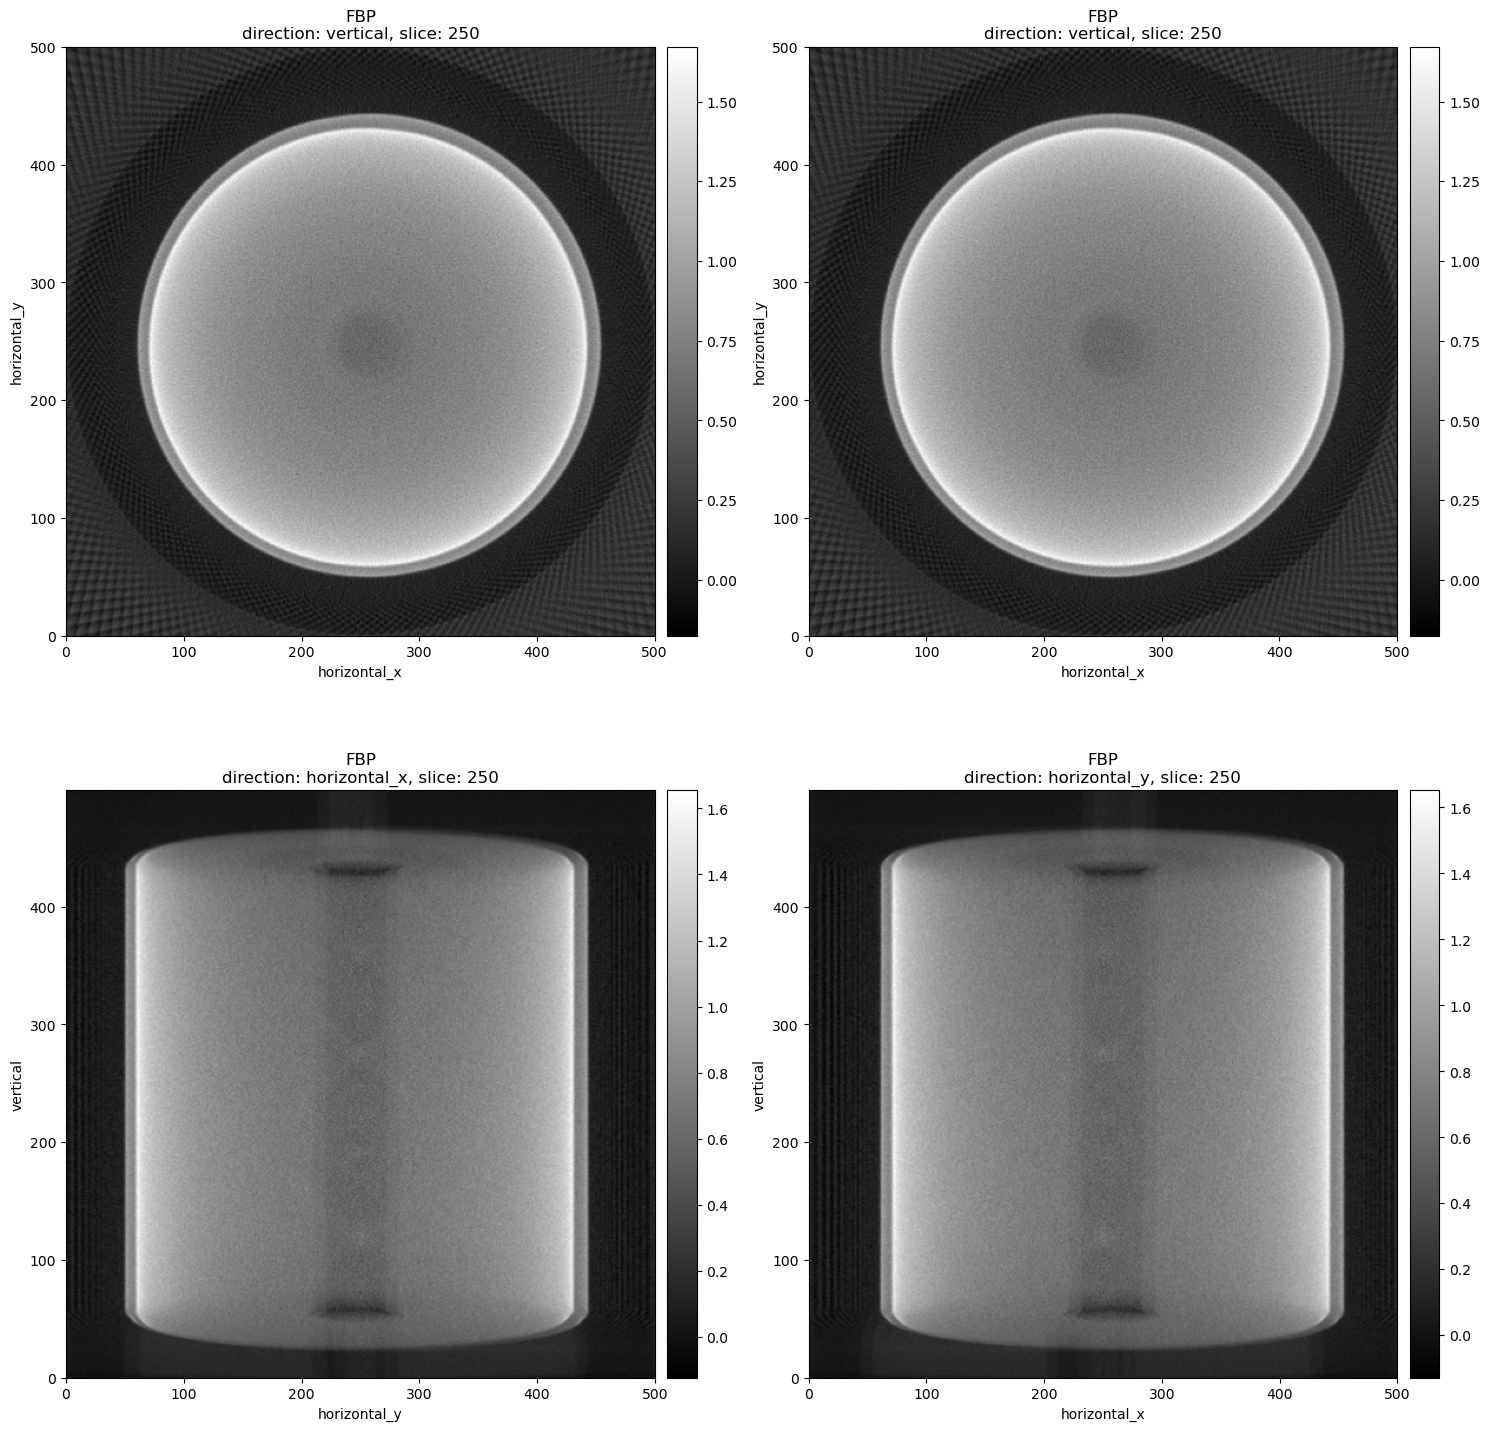

In [42]:
# Distintas formas de visualizar el resultado.

#Se muestra la corte/rebanada en x rebanada.

#show2D(recon,slice_list=[200])
#show2D(recon, title="FDK", slice_list=[400,700,("horizontal_x",410),("horizontal_y",400)])
show2D(recon, title="FBP", slice_list=[250,250,("horizontal_x",250),("horizontal_y",250)])

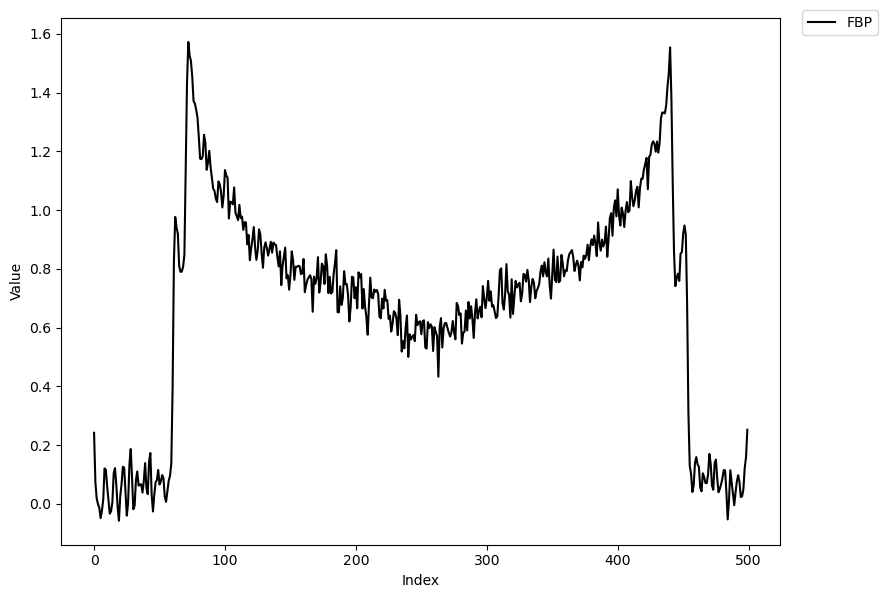

In [21]:
#Se muestra el perfil del corte/rebanada en 250.
show1D([recon], slice_list=[("horizontal_y",250),("vertical",250)], line_colours=["k"], label=["FBP"])

# Reordenar los datos antes de ejecutar los algoritmos iterativos

In [22]:
data_in.reorder('astra')
data_centred.reorder("astra")
ag = data_centred.geometry
ig = ag.get_ImageGeometry()
type(ig)

# Crear el operador de proyección usando Astra-Toolbox
A = ProjectionOperatorAstra(ig, ag, "gpu")


# CGLS

In [23]:
# Configurar CGLS
initial = ig.allocate(0)

# Configurar el objeto CGLS con el número de iteraciones deseado
cgls = CGLS(initial=initial,
            operator=A,
            data=data_centred,
            max_iteration = 10, # Aqui se cambia el número
            update_objective_interval = 1 )

In [24]:
# Ejecutar CGLS
cgls.run(verbose=True)

C:\Users\TalentPC\AppData\Local\Temp\ipykernel_6608\2180278889.py:2: DeprecationWarning: `run()` missing `iterations`
  cgls.run(verbose=True)


  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
# Obtener la solución
recon_cgls = cgls.solution

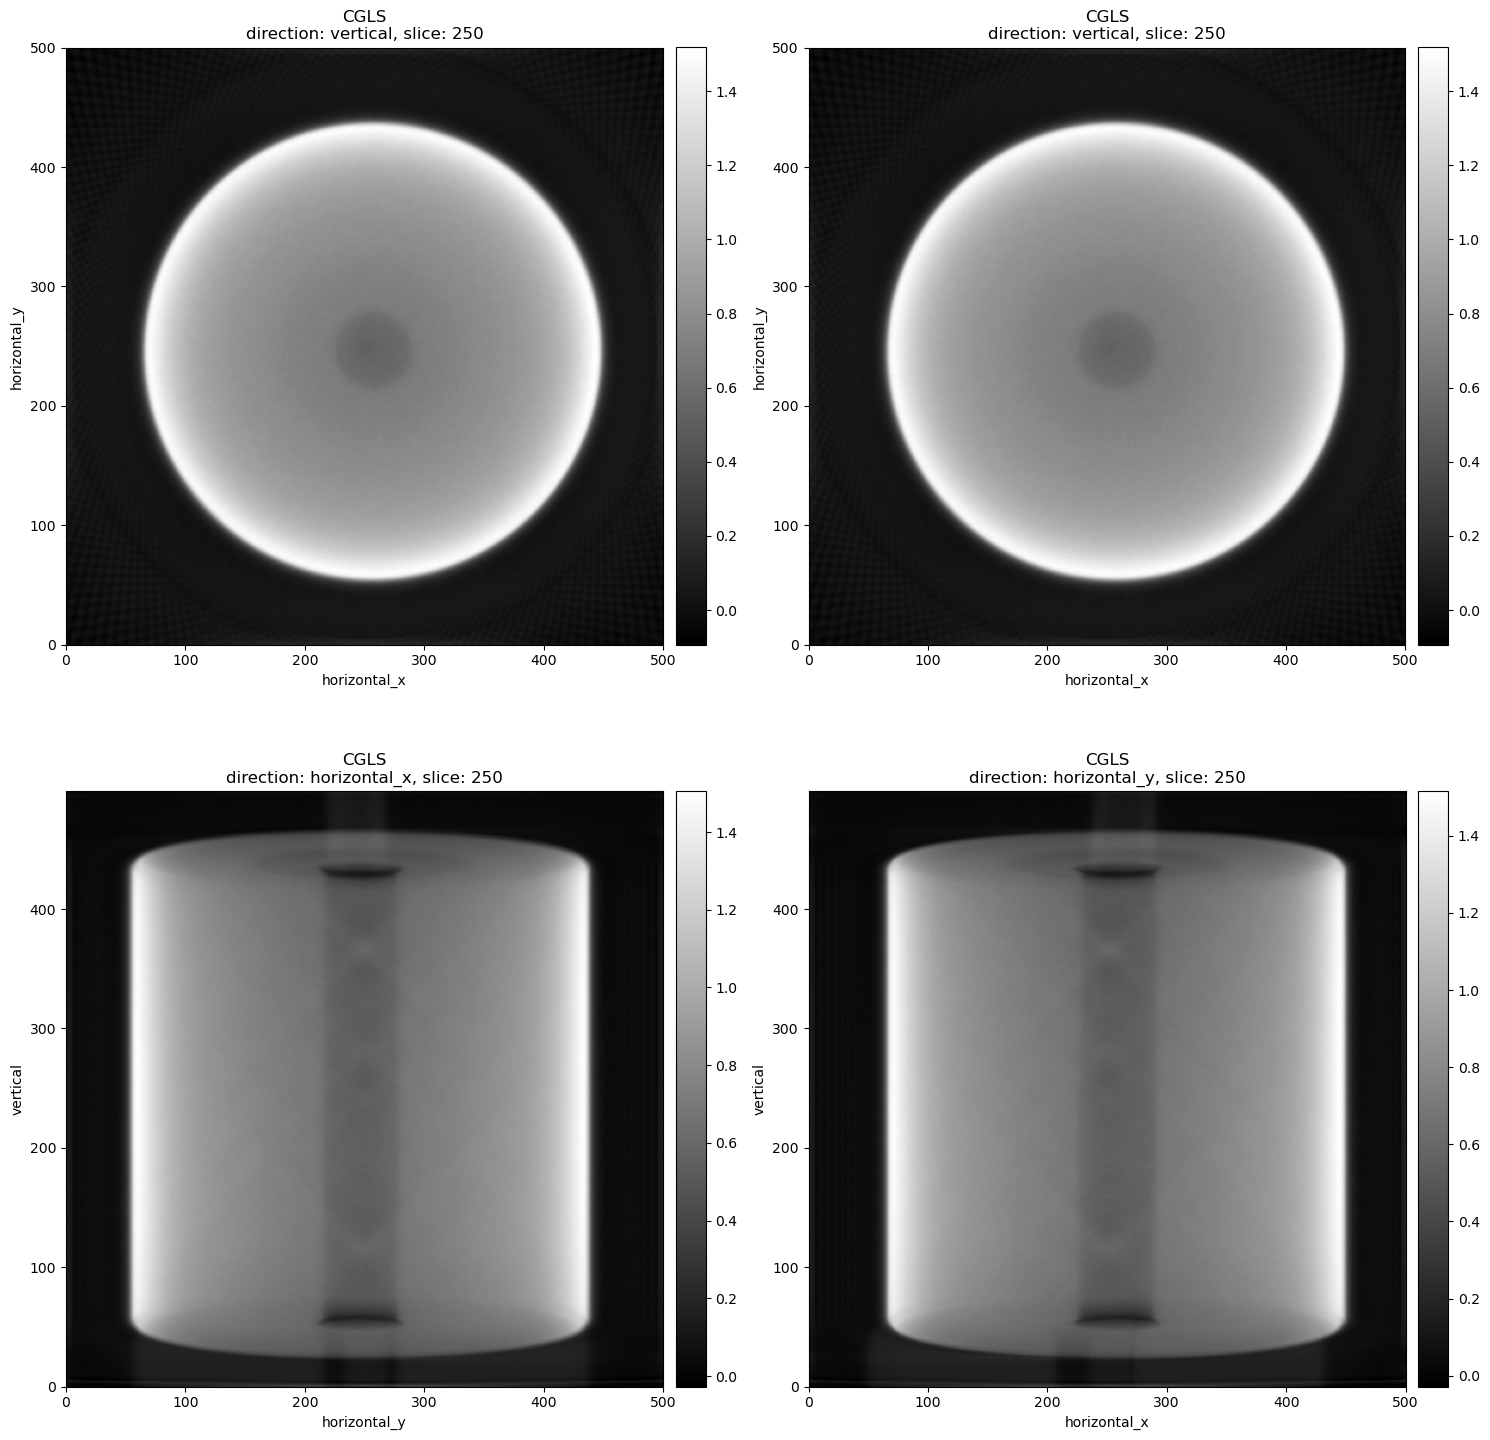

In [26]:
# Distintas formas de visualizar el resultado.

#Se muestra la corte/rebanada en 200.
#show2D(recon_cgls, cmap="gray", slice_list=[200])

#Se muestra la corte/rebanada en 250.
show2D(recon_cgls, title="CGLS", slice_list=[250,250,("horizontal_x",250),("horizontal_y",250)])

# SIRT

In [27]:
# Configurar la caja indicadora
constraint = IndicatorBox(lower=0)

# Configurar el objeto SIRT con el número de iteraciones deseado
sirt = SIRT(initial=initial,
            operator=A,
            data=data_centred,
            constraint=constraint,
            max_iteration = 10 ) # Aqui se cambia el número

sirt.update_objective_interval=1

c:\Users\TalentPC\anaconda3\envs\cil\Lib\site-packages\cil\framework\framework.py:3068: RuntimeWarning: divide by zero encountered in power
  out = pwop(self.as_array() , x2 , *args, **kwargs )


In [28]:
# Ejecutar SIRT
sirt.run(Tverbose=True)

C:\Users\TalentPC\AppData\Local\Temp\ipykernel_6608\928312595.py:2: DeprecationWarning: `run()` missing `iterations`
  sirt.run(Tverbose=True)


  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
# Obtener la solución
recon_sirt_noisy = sirt.solution

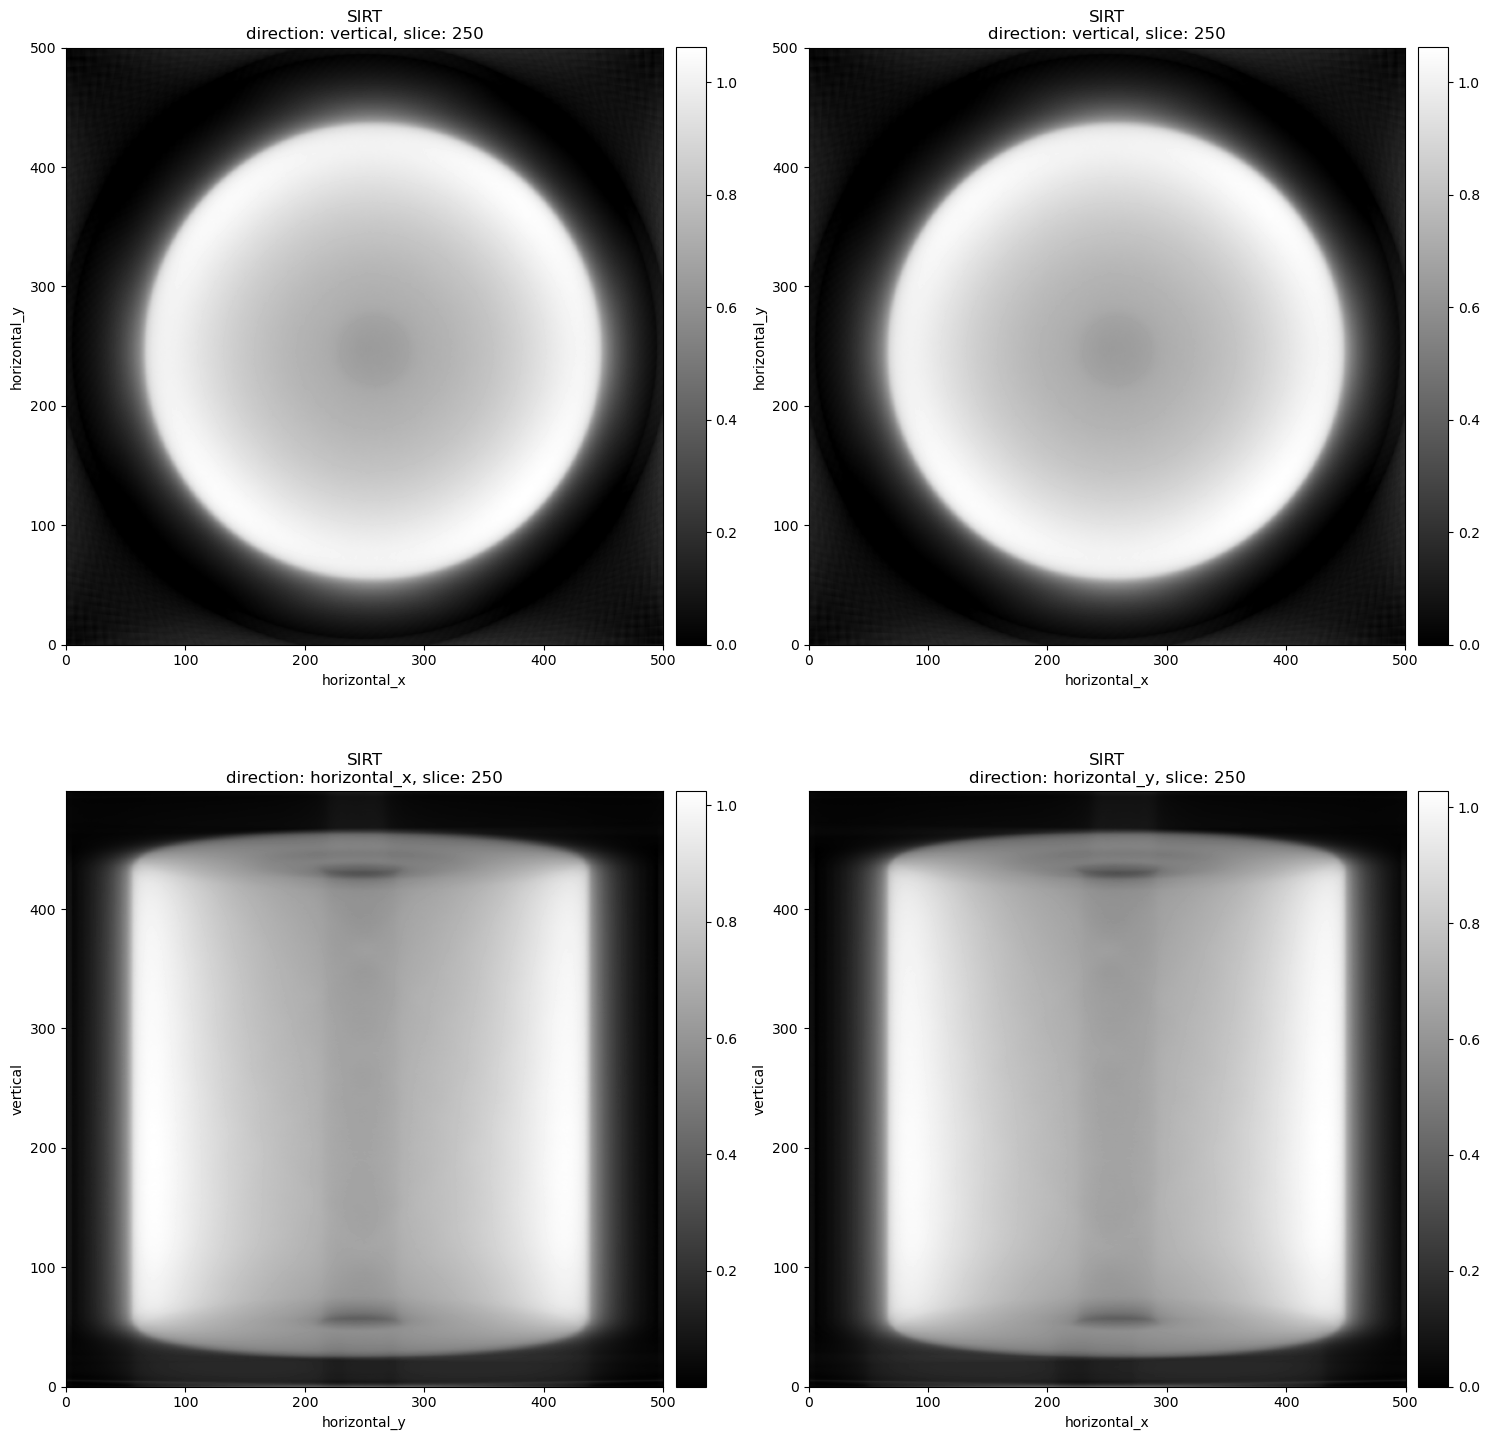

In [30]:
# Distintas formas de visualizar el resultado.

#Se muestra la corte/rebanada en 200.
#show2D(recon_sirt_noisy,  cmap="gray", slice_list=[200])

#Se muestra la corte/rebanada en 250.
show2D(recon_sirt_noisy, title="SIRT", slice_list=[250,250,("horizontal_x",250),("horizontal_y",250)])

# PDHG

In [31]:
# Definir la función y el operador PDHG
F = 1000 * L2NormSquared(b=data_centred)
G = 0.005 * L1Norm()

# Configurar el objeto PDHG con el número de iteraciones deseado
pdhg_l1 = PDHG(
    f = F,
    g = G,
    operator = A,
    max_iteration = 10, # Aqui se cambia el número
    update_objective_interval=1
)

In [32]:
# Ejecutar PDHG
pdhg_l1.run(verbose=True)

C:\Users\TalentPC\AppData\Local\Temp\ipykernel_6608\3410981608.py:2: DeprecationWarning: `run()` missing `iterations`
  pdhg_l1.run(verbose=True)


  0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
# Obtener la solución
recon_pdhg = pdhg_l1.solution

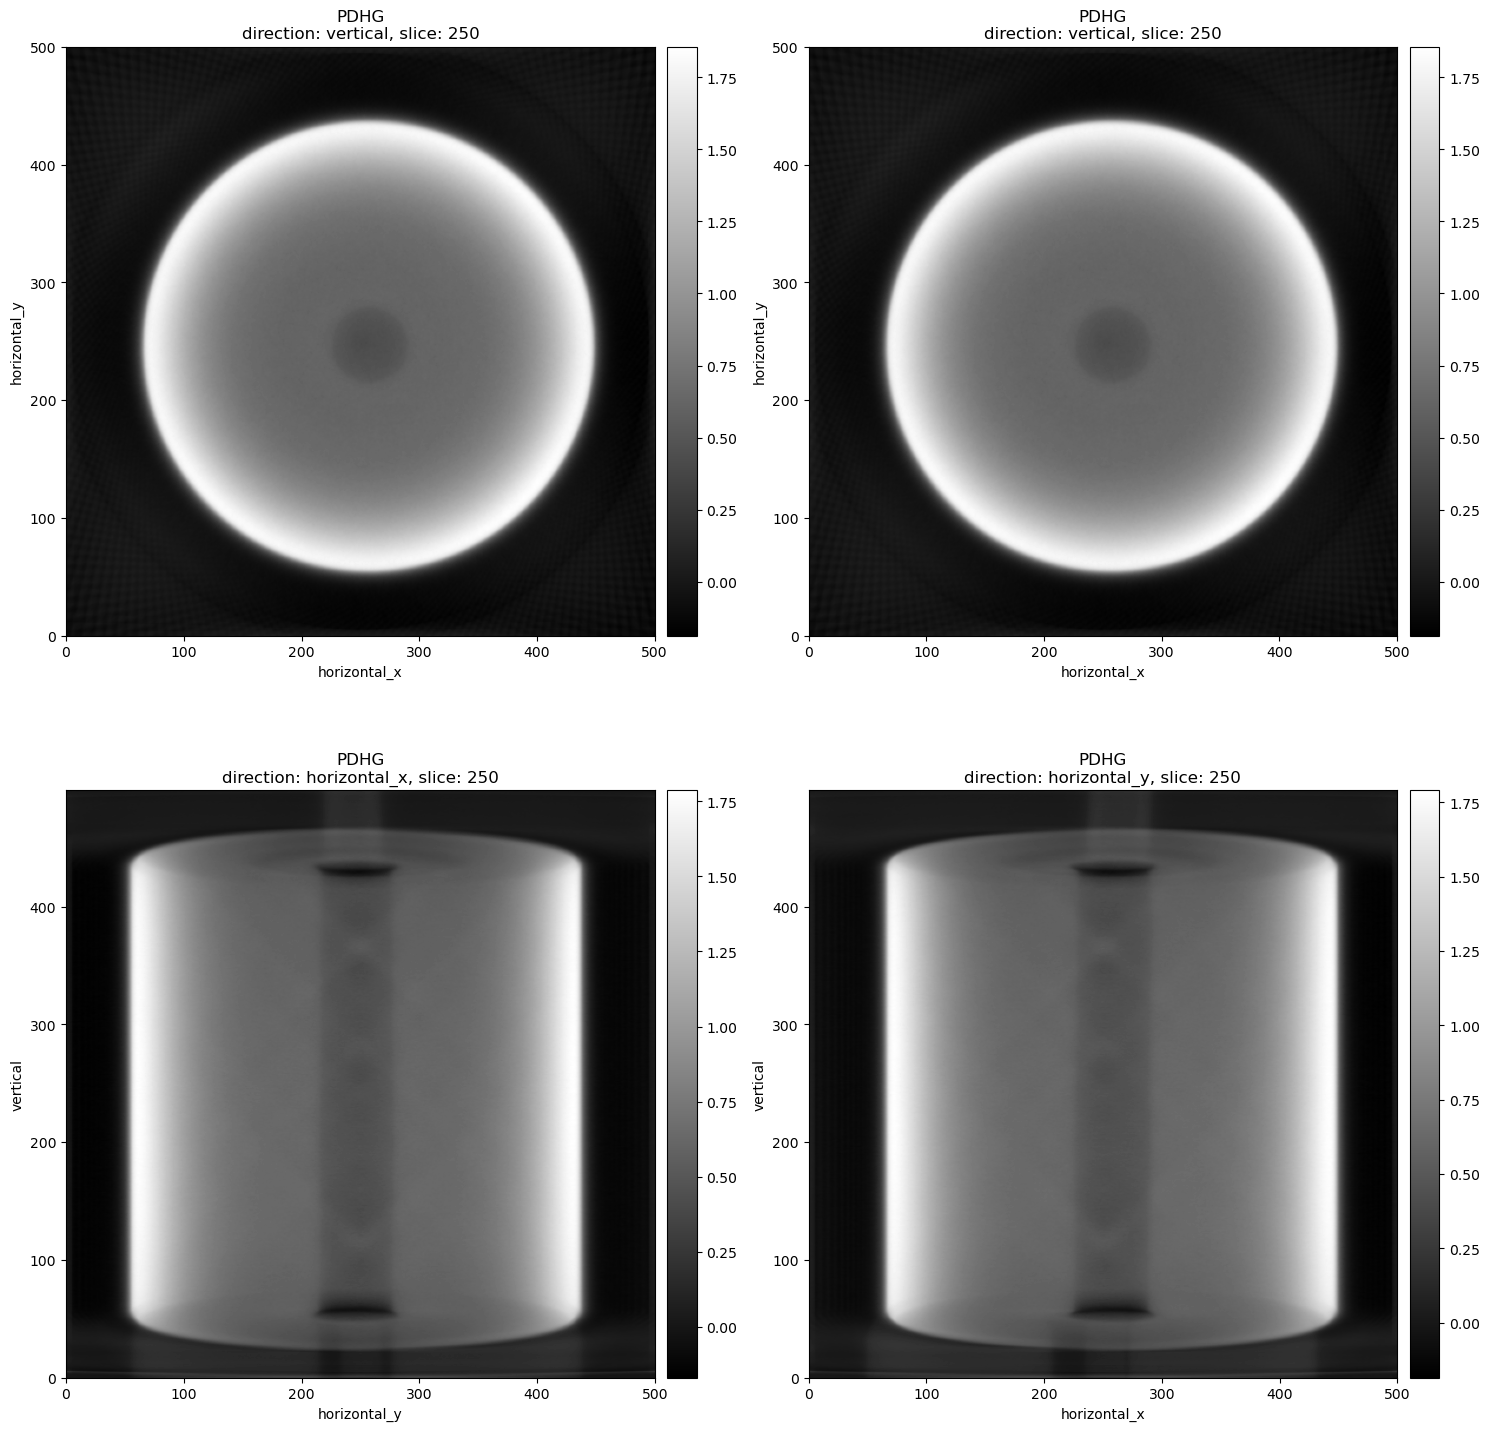

In [34]:
# Distintas formas de visualizar el resultado.

#Se muestra la corte/rebanada en 200.
#show2D(pdhg_l1.solution, cmap="gray", slice_list=[200])

#Se muestra la corte/rebanada en 250.
show2D(pdhg_l1.solution, title="PDHG", slice_list=[250,250,("horizontal_x",250),("horizontal_y",250)])

# Perfiles 1D y respecto a FDK.

## CGLS

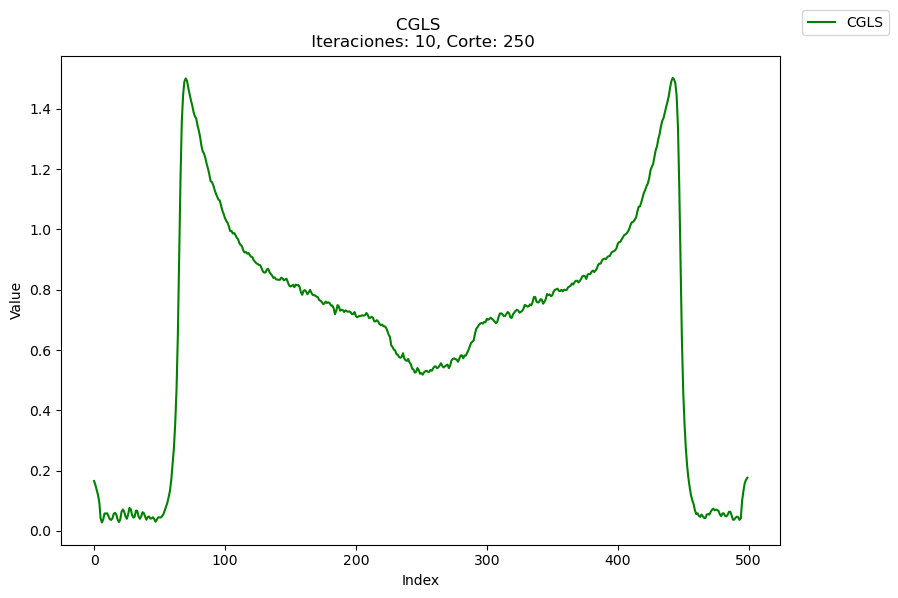

In [35]:
show1D([recon_cgls], title="CGLS \n Iteraciones: 10, Corte: 250", slice_list=[("horizontal_y",250),("vertical",250)], line_colours=["g"], label=["CGLS"])

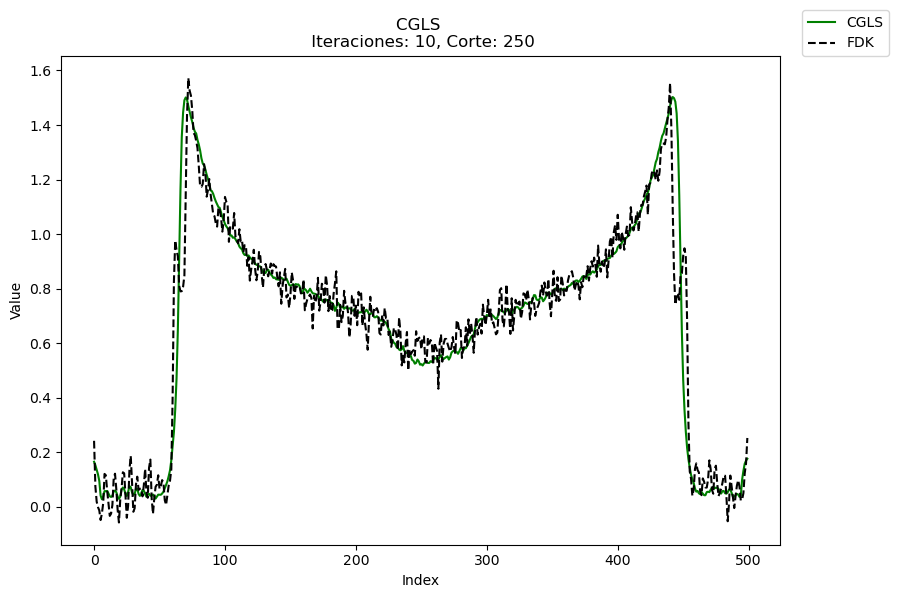

In [36]:
show1D([recon_cgls,recon], title="CGLS \n Iteraciones: 10, Corte: 250", slice_list=[[("horizontal_y",250),("vertical",250)],[("horizontal_y",250),("vertical",250)]], line_colours=["g","k"], label=["CGLS","FDK"])

## SIRT

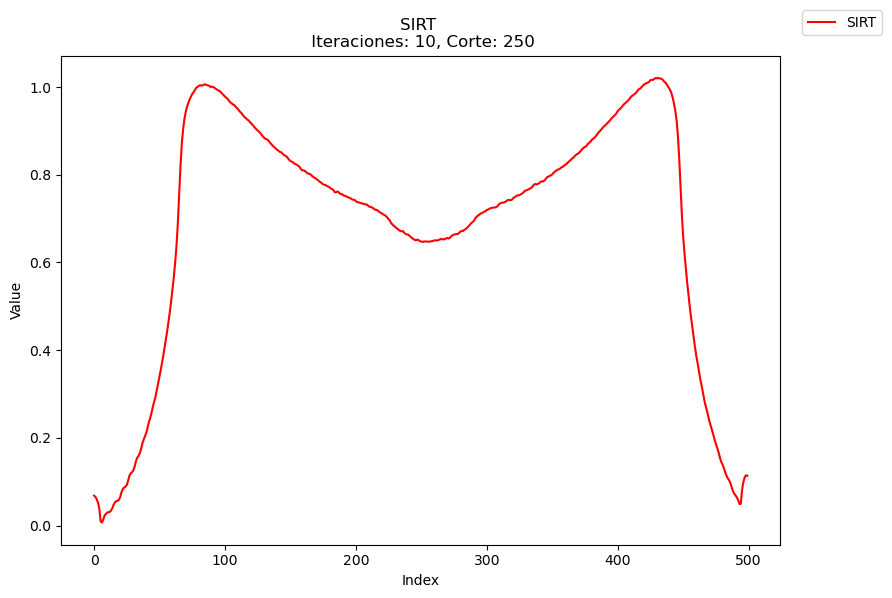

In [37]:
show1D([recon_sirt_noisy], title="SIRT \n Iteraciones: 10, Corte: 250", slice_list=[("horizontal_y",250),("vertical",250)], line_colours=["r"], label=["SIRT"])

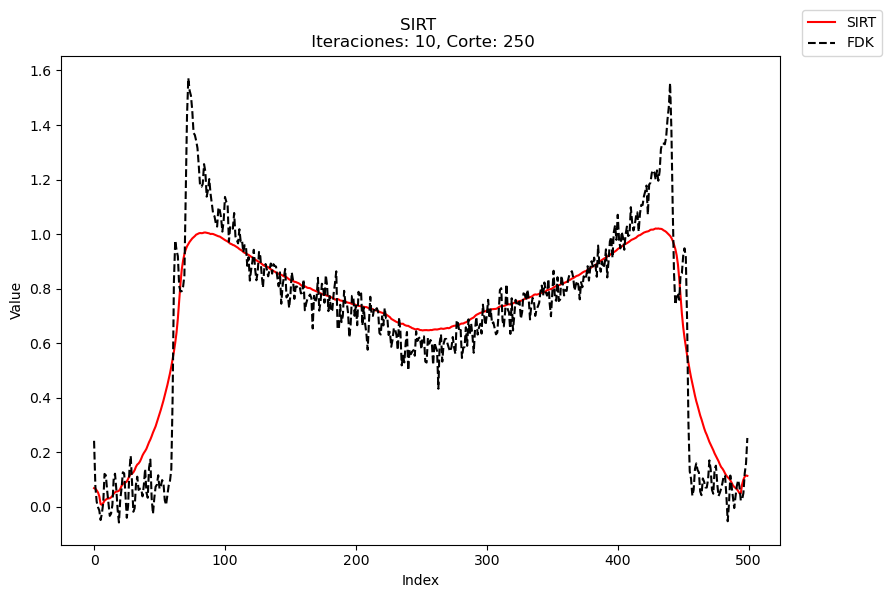

In [38]:
show1D([recon_sirt_noisy,recon], title="SIRT \n Iteraciones: 10, Corte: 250", slice_list=[[("horizontal_y",250),("vertical",250)],[("horizontal_y",250),("vertical",250)]], line_colours=["r","k"], label=["SIRT","FDK"])

## PDHG

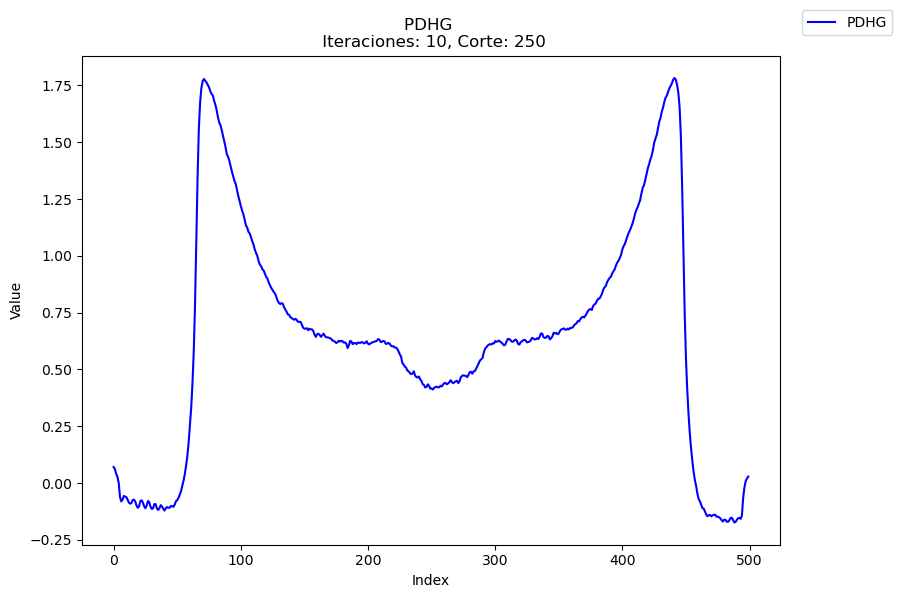

In [39]:
show1D([recon_pdhg], title="PDHG \n Iteraciones: 10, Corte: 250", slice_list=[("horizontal_y",250),("vertical",250)], line_colours=["b"], label=["PDHG"])

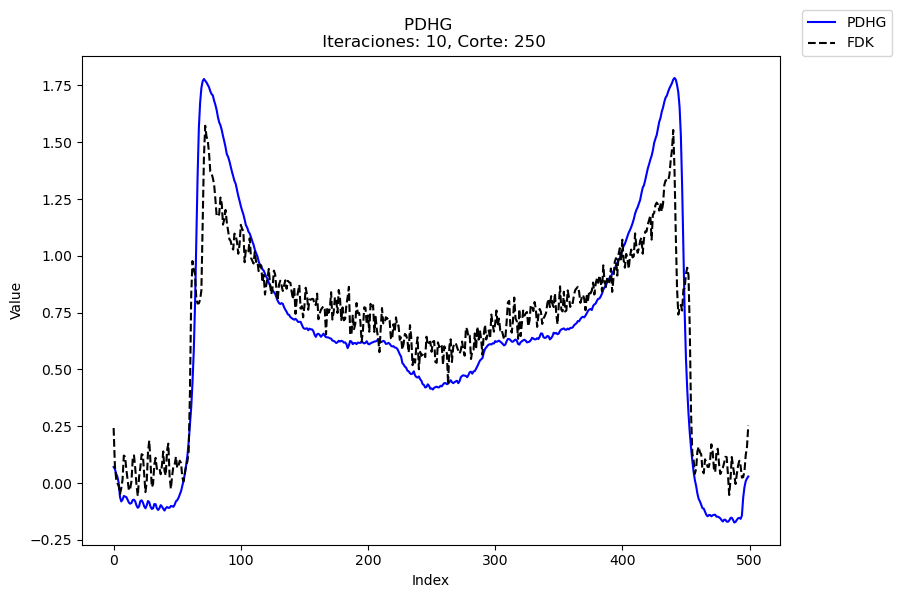

In [40]:
show1D([recon_pdhg,recon], title="PDHG \n Iteraciones: 10, Corte: 250", slice_list=[[("horizontal_y",250),("vertical",250)],[("horizontal_y",250),("vertical",250)]], line_colours=["b","k"], label=["PDHG","FDK"])

# Todos los perfiles

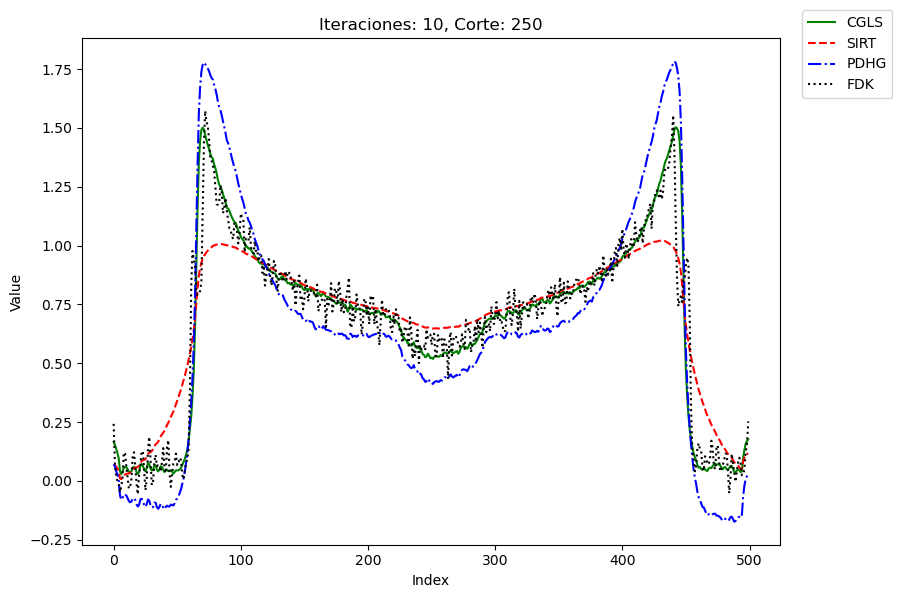

In [41]:
show1D([recon_cgls, recon_sirt_noisy, recon_pdhg, recon], title="Iteraciones: 10, Corte: 250", slice_list=[("horizontal_y",250),("vertical",250)], line_colours=["g","r","b","k"], label=[ "CGLS","SIRT","PDHG","FDK"])